In [20]:
import plotly.graph_objects as go
import csv
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal, ROUND_HALF_UP
from collections import Counter


In [21]:
# Initialize bins and matrices
price_levels = 101  # 0.00 to 1.00 by 0.01
time_steps = 100    # 0 to 99

event_matrix = np.zeros((price_levels, time_steps))
total_matrix = np.zeros((price_levels, time_steps))

markets = 0
winnerTokens = 0
market_durations = []
tag_counter = Counter()
with open("processed_markets.csv", newline="", encoding="utf-8") as csvfile:
    reader = csv.DictReader(csvfile)

    for i, row in enumerate(reader):
        try:
            # Get resampled prices from price_0 to price_99
            resampled_prices = np.array([Decimal(row[f"price_{j}"]) for j in range(100)])
        except Exception as e:
            print(f"Error parsing prices in market row {i+1}: {e}")
            continue

        markets += 1
        duration_seconds = int(row["end"]) - int(row["start"])
        market_durations.append(duration_seconds)

        tags = eval(row["tags"])
        tags = [t for t in tags if t.lower() != "all"]
        tag_counter.update(set(tags))

        winner_token = row["winner_token"]
        event_occurred = 1 if winner_token == "True" else 0
        winnerTokens += event_occurred

        # Fill matrices
        for time_idx, price in enumerate(resampled_prices):
            # Round to two decimal places (specifically rounding up)
            rounded = price.quantize(Decimal('0.01'), rounding=ROUND_HALF_UP)
            price_idx = int(rounded * 100)
            #print(f"{time_idx}/{time_steps}: {price} -> {price_idx}")
            #print(price, rounded, price_idx)
            #time.sleep(1)  #
            event_matrix[price_idx, time_idx] += event_occurred
            total_matrix[price_idx, time_idx] += 1

# Normalize
normalized_matrix = np.divide(event_matrix, total_matrix, where=total_matrix > 0) * 100
mask = total_matrix < 10
normalized_matrix[mask] = np.nan
print(f"Dataset contains {markets} markets")
print(f"{winnerTokens} winner Tokens, {markets - winnerTokens} loser tokens")
print(f"Markets contain {len(tag_counter)} tags")


Dataset contains 34744 markets
12021 winner Tokens, 22723 loser tokens
Markets contain 3138 tags


# Markets

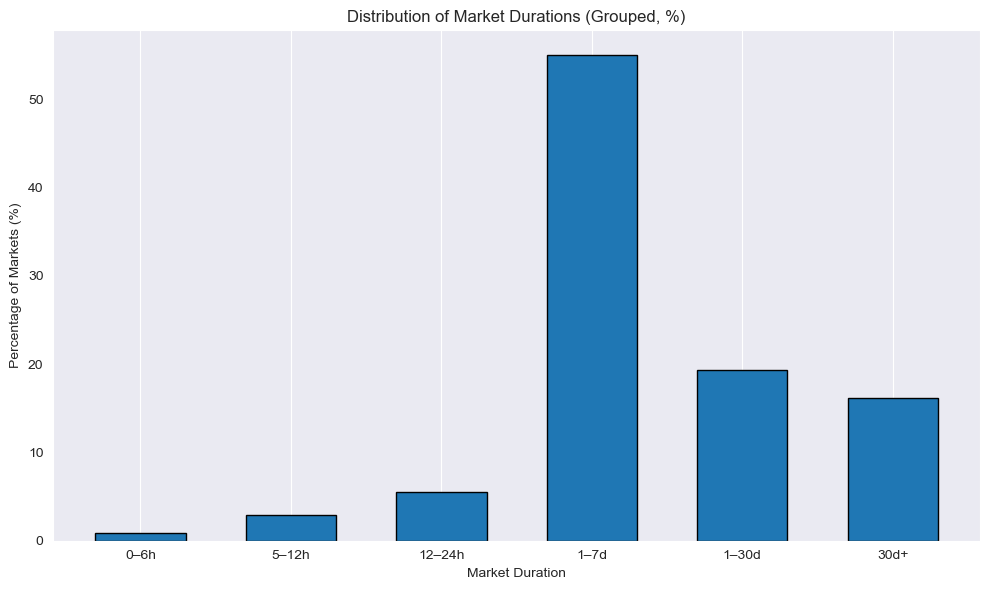

In [23]:
durations_in_hours = [s / 3600 for s in market_durations]

# [0–5, 5–12, 12–24, 24–168, 168–720, 720+]
bin_edges = [0, 6, 12, 24, 168, 720, float("inf")]
bin_labels = ["0–6h", "5–12h", "12–24h", "1–7d", "1–30d", "30d+"]

# Use numpy histogram with bins
counts, _ = np.histogram(durations_in_hours, bins=bin_edges)

# Convert to percentages
total = np.sum(counts)
percentages = (counts / total) * 100

# Plot
plt.figure(figsize=(10, 6))
plt.bar(bin_labels, percentages, width=0.6, edgecolor='black')
plt.xlabel("Market Duration")
plt.ylabel("Percentage of Markets (%)")
plt.title("Distribution of Market Durations (Grouped, %)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

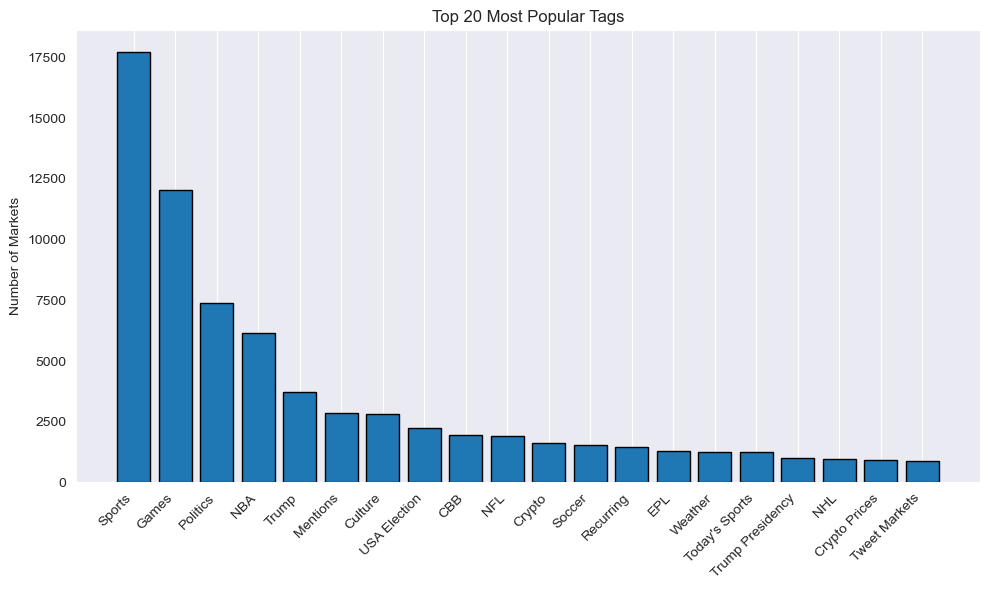

In [24]:
top_20_tags = tag_counter.most_common(20)
# Extract tag names and their counts
tags, counts = zip(*top_20_tags)

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(tags, counts, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Number of Markets")
plt.title("Top 20 Most Popular Tags")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Price distribution

In [25]:
fig = go.Figure(data=[go.Surface(z=total_matrix)])

fig.update_layout(
    title='Price samples over Time',
    scene=dict(
        xaxis_title='Time (0-100)',
        yaxis_title='Price (0-100)',
        zaxis_title='Occurrence',
    ),
    autosize=False,
    margin=dict(l=50, r=50, b=50, t=50)
)

fig.show()

In [27]:
under_100_count = np.sum(total_matrix < 100)
print(f"Anzahl Zeit-Preis Situationen mit total < 100 Samples: {under_100_count}")

under_10_count = np.sum(total_matrix < 10)
print(f"Anzahl Zeit-Preis Situationen mit total < 10 Samples: {under_10_count}")

# Get the indices where total_matrix has less than 10 observations
indices_less_than_10 = np.where(total_matrix < 10)

# Extract row (prices) and column (times) indices
rows, cols = indices_less_than_10

# Map the indices back to price and time step values
prices = np.linspace(0, 1, total_matrix.shape[0])  # Price levels (0-100 scaled to 0-1)
times = np.arange(total_matrix.shape[1])  # Time steps (0 to 99)

# Group by time and count how many prices have less than 10 observations for each time
time_less_than_10_count_dict = {}

# Collect prices with less than 10 observations
for i in range(len(rows)):
    time = times[cols[i]]
    price = prices[rows[i]]

    if time not in time_less_than_10_count_dict:
        time_less_than_10_count_dict[time] = []

    time_less_than_10_count_dict[time].append(price)  # Add the price with <10 observations for this time

# Print results: for each time, print how many prices have < 10 observations and the actual prices
for time, less_than_10_prices in time_less_than_10_count_dict.items():
    print(f"Time: {time} - Number of prices with less than 10 observations: {len(less_than_10_prices)}")
    print(f"Prices with less than 10 observations: {less_than_10_prices}\n")

Anzahl Zeit-Preis Situationen mit total < 100 Samples: 1969
Anzahl Zeit-Preis Situationen mit total < 10 Samples: 90
Time: 0 - Number of prices with less than 10 observations: 18
Prices with less than 10 observations: [0.0, 0.79, 0.8200000000000001, 0.8300000000000001, 0.84, 0.86, 0.87, 0.89, 0.91, 0.92, 0.93, 0.9400000000000001, 0.9500000000000001, 0.96, 0.97, 0.98, 0.99, 1.0]

Time: 99 - Number of prices with less than 10 observations: 63
Prices with less than 10 observations: [0.09, 0.11, 0.14, 0.16, 0.17, 0.18, 0.19, 0.21, 0.22, 0.23, 0.26, 0.27, 0.28, 0.29, 0.31, 0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37, 0.38, 0.39, 0.41000000000000003, 0.42, 0.43, 0.46, 0.54, 0.55, 0.56, 0.5700000000000001, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.6900000000000001, 0.7000000000000001, 0.71, 0.72, 0.73, 0.74, 0.77, 0.78, 0.79, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84, 0.85, 0.86, 0.87, 0.89, 0.91, 0.92, 0.93, 0.9400000000000001]

Time: 98 - Number of pr

In [28]:
# Normalize each column (time slice) of total_matrix to get percentage of markets at each price
percentage_matrix = np.zeros_like(total_matrix)

for time_idx in range(total_matrix.shape[1]):
    column_sum = total_matrix[:, time_idx].sum()
    if column_sum > 0:
        percentage_matrix[:, time_idx] = total_matrix[:, time_idx] / column_sum * 100

fig = go.Figure(data=[go.Surface(z=percentage_matrix)])

fig.update_layout(
    title='Price Distribution (% of Markets) Over Time',
    scene=dict(
        xaxis_title='Time',
        yaxis_title='Price',
        zaxis_title='Percentage of Markets',
    ),
    autosize=True,
    margin=dict(l=50, r=50, b=50, t=50)
)

fig.show()

In [29]:
fig = go.Figure(data=go.Heatmap(
    z=percentage_matrix,
    x=list(range(percentage_matrix.shape[1])),  # Time steps (0-99)
    y=list(range(percentage_matrix.shape[0])),  # Prices 0.00 to 1.00
    colorscale='Viridis',
    colorbar=dict(title='Percentage of Markets')
))

fig.update_layout(
    title='Price Distribution (% of Markets) Over Time',
    xaxis=dict(
        title='Time Step',
        tickmode='auto',                # Autoscale tick values
        range=[0, 100],                  # Range from 0 to 100 to ensure it shows up till 100
    ),
    yaxis_title='Price',
    autosize=False,
    margin=dict(l=50, r=50, b=50, t=50)
)

fig.show()

In [30]:
price_levels, time_steps = percentage_matrix.shape
center = price_levels // 2       # 101 bins → center = 50
max_dist = center                # max distance is 50

# Precompute distance index for each price index
dist_indices = np.abs(np.arange(price_levels) - center)

# Allocate distance_matrix: rows 0…50, cols = time_steps
distance_matrix = np.zeros((max_dist + 1, time_steps))

# Aggregate directly by distance index
for price_idx in range(price_levels):
    d = dist_indices[price_idx]
    distance_matrix[d, :] += percentage_matrix[price_idx, :]


x = np.arange(distance_matrix.shape[1])  # time steps
y = np.arange(distance_matrix.shape[0])  # distance from 0.5

X, Y = np.meshgrid(x, y)

fig = go.Figure(data=[go.Surface(
    x=X,
    y=Y,
    z=distance_matrix,
    #colorscale='Viridis',
    colorbar=dict(title='Percentage of Markets', title_side='right')
)])

fig.update_layout(
    title='Price Distance from 50 Over Time',
    scene=dict(
        xaxis_title='Time Step',
        yaxis_title='Distance from 50',
        zaxis_title='% of Markets'
    ),
    autosize=False,
    margin=dict(l=70, r=70, b=70, t=70)
)

fig.show()

In [31]:
fig = go.Figure(data=go.Heatmap(
    z=distance_matrix,
    x=list(range(distance_matrix.shape[1])),  # Time steps
    y=list(range(distance_matrix.shape[0])),  # Distance
    #colorscale='Viridis',
    #colorscale=[
    #    [0.0, "blue"],
    #    [0.5, "yellow"],
    #    [1.0, "red"]
    #],
    colorbar=dict(title='Percentage of Markets', title_side='right')
))

fig.update_layout(
    title='Price Distance from 50 Over Time',
    xaxis=dict(
        title='Time Step',
        tickmode='auto',                # Autoscale tick values
        range=[0, 100],                  # Range from 0 to 100 to ensure it shows up till 100
    ),
    yaxis_title='Distance from 50',
    autosize=False,
    margin=dict(l=50, r=50, b=50, t=50)
)

fig.show()

# Probability

In [32]:
fig = go.Figure(data=[go.Surface(z=normalized_matrix)])

fig.update_layout(
    title='Probability Surface Over Price at Time',
    scene=dict(
        xaxis_title='Time',
        yaxis_title='Price',
        zaxis_title='Event Probability',
    ),
    autosize=False,
    margin=dict(l=30, r=30, b=30, t=30)
)

fig.show()

In [33]:
fig = go.Figure(data=go.Heatmap(
    z=normalized_matrix,
    x=list(range(normalized_matrix.shape[1])),  # Time steps (0-99)
    y=list(range(normalized_matrix.shape[0])),  # Prices 0.00 to 1.00
    colorscale='Viridis',
    colorbar=dict(title='Event Probability')  # or 'Occurrence' or 'Percentage'
))

fig.update_layout(
    title='Probability Heatmap Over Price at Time',
    xaxis=dict(
        title='Time Step',
        tickmode='auto',                # Autoscale tick values
        range=[0, 100],                  # Range from 0 to 100 to ensure it shows up till 100
    ),
    yaxis_title='Price',
    autosize=False,
    margin=dict(l=50, r=50, b=50, t=50)
)

fig.show()

# Mispricing

In [34]:
# Mispricing = |Normalized Price - True Probability (Price)|
# Adjusted for price range from 0 to 100
mispricing_matrix = np.abs(normalized_matrix - np.linspace(0, 100, normalized_matrix.shape[0]).reshape(-1, 1))

# Plotting Mispricing in 3D (Price vs Time vs Mispricing)
fig = go.Figure(data=go.Surface(
    z=mispricing_matrix,  # Mispricing values (absolute difference)
    x=np.arange(mispricing_matrix.shape[1]),  # Time Steps (0 to 99)
    y=np.linspace(0, 100, mispricing_matrix.shape[0]),  # Price levels (0 to 100)
    colorscale='RdYlGn_r',  # Red for higher mispricing, Green for lower mispricing
    colorbar=dict(title="Mispricing")
))

fig.update_layout(
    title="Mispricing: Deviation from True Probability",
    scene=dict(
        xaxis_title='Time',
        yaxis_title='Price',
        zaxis_title='Mispricing'
    ),
    autosize=False,
    margin=dict(l=60, r=50, b=50, t=50)
)

fig.show()

In [35]:
# True Probability (Ideal) should just be the price itself (0-100 range)
prices = np.linspace(0, 100, normalized_matrix.shape[0]).reshape(-1, 1)

# Calculate deviation between normalized price and true probability
deviation_matrix = normalized_matrix - prices
# Positive = Probability was higher than price = underpricing
# Negative = Probability was lower than price = overpricing

# Plotting the deviation in 3D
max_abs_deviation = np.max(np.abs(deviation_matrix))

fig = go.Figure(data=go.Surface(
    z=deviation_matrix,
    x=np.arange(deviation_matrix.shape[1]),  # Time Steps
    y=np.linspace(0, 100, deviation_matrix.shape[0]),  # Price levels
    colorscale=[
        [0.0, "red"],     # far negative
        [0.49, "orange"],        # still negative
        [0.5, "white"],        # hard split point at zero
        [0.51, "turquoise"],  # immediately positive
        [1.0, "darkgreen"]    # far positive
    ],
    cmin=-max_abs_deviation,
    cmax=max_abs_deviation,
    colorbar=dict(
        title='Probability Deviation from Price',
        title_side='right'
    )
))


fig.update_layout(
    title="Probability Deviation from Price",
    scene=dict(
        xaxis_title='Time Step',
        yaxis_title='Price',
        zaxis_title='Deviation'
    ),
    autosize=False,
    margin=dict(l=30, r=30, b=30, t=30)
)

fig.show()

In [36]:
# Create the heatmap

fig = go.Figure(data=go.Heatmap(
    z=deviation_matrix,
    x=list(range(deviation_matrix.shape[1])),  # Time Steps
    y=np.linspace(0, 100, deviation_matrix.shape[0]),  # Price levels
    colorscale=[
        [0.0, "red"],        # far negative
        [0.49, "orange"],    # still negative
        [0.5, "white"],      # hard split at zero
        [0.51, "turquoise"], # immediately positive
        [1.0, "darkgreen"]   # far positive
    ],
    zmin=-max_abs_deviation,
    zmax=max_abs_deviation,
    colorbar=dict(
        title='Probability Deviation from Price',
        title_side='right'
    )
))

fig.update_layout(
    title='Probability Deviation from Price',
    xaxis_title='Time Step',
    yaxis_title='Price',
    autosize=False,
    margin=dict(l=50, r=50, b=50, t=50)
)

fig.show()